In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel
from backends.plot             import plot_data, plot_ratio, plot_pull
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

import backends.plot as plot

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
#  Inputs config

cWtil_vals = [0, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]

input_fnames = {}
input_fnames [0   ] = "../Data/SM_EWK_1M_rivet_output.pickle"
input_fnames [-0.4] = "../Data/cWtil_m0p4_full_200k_rivet_output.pickle"
input_fnames [-0.3] = "../Data/cWtil_m0p3_full_200k_rivet_output.pickle"
input_fnames [-0.2] = "../Data/cWtil_m0p2_full_200k_rivet_output.pickle"
input_fnames [-0.1] = "../Data/cWtil_m0p1_full_200k_rivet_output.pickle"
input_fnames [ 0.1] = "../Data/cWtil_0p1_full_200k_rivet_output.pickle"
input_fnames [ 0.2] = "../Data/cWtil_0p2_full_200k_rivet_output.pickle"
input_fnames [ 0.3] = "../Data/cWtil_0p3_full_200k_rivet_output.pickle"
input_fnames [ 0.4] = "../Data/cWtil_0p4_full_200k_rivet_output.pickle"


In [3]:
#  Model config

output_size_per_stage     = 10
max_epochs                = 200
batch_size                = 200
epoch_increase_per_level  = 500
early_stopping_patience   = 5
early_stopping_min_delta  = 0
validation_split          = 0.5

white_linear_fraction_data  = 0.5
white_linear_fraction_gauss = 0.
whitening_num_points        = 400

load_whitening_funcs = None # ".whitening_funcs.pickle"
save_whitening_funcs = ".whitening_funcs.pickle"

load_model_dir = None
save_model_dir = ".EWK_density_model"


In [4]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "m_ll", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order = ["m_jj", "Dy_j_j", "Dphi_j_j"]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables


In [5]:
#  Load and format the data
#

data_tables = {}
for cWtil in cWtil_vals :
    input_fname = input_fnames [cWtil]
    print(f"Creating data table for cWtil={cWtil}")
    print(f" -- events from file {input_fname}")
    data = DataTable(input_fname)
    print(f" -- Table created with {data.get_num_events()} events")
    for observable, limits in observable_limits.items() :
        print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
        data.filter(observable, limits[0], limits[1])
        print(f" -- {data.get_num_events()} events survived")
    for observable in remove_observables :
        print(f" -- removing observable {observable}")
        data.remove_column(observable)
    print(" -- ordering observables")
    data.reorder(*observables_order)
    data.print_summary()
    data_tables [cWtil] = data
    

Creating data table for cWtil=0
 -- events from file ../Data/SM_EWK_1M_rivet_output.pickle
 -- Table created with 1000000 events
 -- filtering observable m_ll between 75 and 105
 -- 660799 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 660766 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 660766 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 652255 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 643177 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 643177 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 643177 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 643177 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 643054 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 642591 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 642591 events s

 -- 128530 events survived
 -- removing observable N_jets
 -- removing observable m_ll
 -- removing observable pT_ll
 -- removing observable rap_ll
 -- removing observable theta_ll
 -- removing observable pT_jj
 -- removing observable theta_jj
 -- removing observable rap_jj
 -- removing observable pT_j1
 -- removing observable pT_j2
 -- removing observable N_gap_jets
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | m_jj     | <class 'float'> |
    | 1      | Dy_j_j   | <class 'float'> |
    | 2      | Dphi_j_j | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 1.1468         |
    +-------------------------+

* Number of events       : 128530
* Cross section per event: 0.253

 -- 132342 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 132326 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 132326 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 130576 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 128713 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 128713 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 128713 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 128713 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 128683 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 128598 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 128598 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 128598 events survived
 -- filtering observable N_jets between 2 and 5
 -- 128598 e

In [6]:

whitening_funcs = None
if (type(load_whitening_funcs) != type(None)) :
    print(f"Loading whitening functions from file {load_whitening_funcs}")
    whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))

axis_configs = [[observable_limits[key][0], observable_limits[key][1], whitening_num_points,  white_linear_fraction_data, white_linear_fraction_gauss] for key in data.keys]

observable_data, weight_data, white_data_to_fit = {}, {}, {}
for cWtil in cWtil_vals :
    data = data_tables [cWtil]
    #  Seperate data from weights
    observable_data [cWtil], weight_data [cWtil] = data.get_observables_and_weights()
    #  Whiten data
    print(f"Whitening dataset for cWtil={cWtil}")
    white_data_to_fit[cWtil], whitening_funcs = whiten_axes (observable_data[cWtil], data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=data.get_weights())

if type(save_whitening_funcs) != type(None) :
    print(f"Saving whitening functions to file {save_whitening_funcs}")
    pickle.dump(whitening_funcs, open(save_whitening_funcs, "wb"))

weights_to_fit = {k:i/np.sum(i) for k,i in weight_data.items()}


Whitening dataset for cWtil=0
Whitening dataset for cWtil=-0.4
Whitening dataset for cWtil=-0.3
Whitening dataset for cWtil=-0.2
Whitening dataset for cWtil=-0.1
Whitening dataset for cWtil=0.1
Whitening dataset for cWtil=0.2
Whitening dataset for cWtil=0.3
Whitening dataset for cWtil=0.4
Saving whitening functions to file .whitening_funcs.pickle


In [7]:

#weights_to_fit = {k:(1+np.fabs(k)/np.max(np.fabs(cWtil_vals)))*i/np.sum(i) for k,i in weight_data.items()}


In [8]:
#  Load model if requested, otherwise build and fit
#

if type(load_model_dir) != type(None) :
    density_model = DensityModel.from_dir(load_model_dir)
else :
    #  Create density model
    density_model = DensityModel(name            = "QCD_density_model", 
                                 num_gaussians   = output_size_per_stage, 
                                 num_conditions  = 1, 
                                 num_observables = data.get_num_observables(), 
                                 types           = data.types,
                                 int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data.keys, data.types)) if t == int},
                                 verbose         = True)
    fit_times = {}
    for obs_idx in range(white_data_to_fit[0.2].shape[1]) :
        fit_start_time = time.time()
        num_epochs = max_epochs + obs_idx*epoch_increase_per_level
        density_model.fit(white_data_to_fit, 
                          weights_to_fit,
                          observable                = obs_idx,
                          max_epochs_per_observable = num_epochs,
                          early_stopping_patience   = early_stopping_patience,
                          early_stopping_min_delta  = early_stopping_min_delta,
                          validation_split          = validation_split,
                          batch_size_per_observable = batch_size)
        fit_times [obs_idx] = [num_epochs, time.time() - fit_start_time]


INFO       DensityModel.construct      Set model name           : QCD_density_model
INFO       DensityModel.construct      Set model num_gaussians  : 10
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 3
INFO       DensityModel.construct      Set observable types     : [<class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.build          Building model segment: QCD_density_model_observable0 for observable index 0
Creating continuous density model: QCD_density_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 10
Instructions for updating:
Colocations handled automatically by placer.
Model: "QCD_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLaye

Model: "QCD_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 7)            14          input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 6)            18          input_5[0][0]                    
______________________________________________________________________

835753/835753 [==============================] - 17s 20us/step - loss: 3.1378e-06 - val_loss: 3.1381e-06
Epoch 6/700
835753/835753 [==============================] - 17s 20us/step - loss: 3.1350e-06 - val_loss: 3.1346e-06
Epoch 7/700
835753/835753 [==============================] - 17s 20us/step - loss: 3.1335e-06 - val_loss: 3.1330e-06
Epoch 8/700
835753/835753 [==============================] - 17s 20us/step - loss: 3.1324e-06 - val_loss: 3.1330e-06
Epoch 9/700
835753/835753 [==============================] - 18s 21us/step - loss: 3.1312e-06 - val_loss: 3.1344e-06
Epoch 10/700
835753/835753 [==============================] - 17s 21us/step - loss: 3.1311e-06 - val_loss: 3.1359e-06
Epoch 11/700
835753/835753 [==============================] - 18s 21us/step - loss: 3.1297e-06 - val_loss: 3.1318e-06
Epoch 12/700
835753/835753 [==============================] - 17s 21us/step - loss: 3.1281e-06 - val_loss: 3.1291e-06
Epoch 13/700
835753/835753 [==============================] - 17s 21us/st

In [9]:
#  Use this cell to add training epochs to whichever indices appear undertrained

improve_indices   = [0, 1, 2]
impove_batch_size = 100000
impove_num_epochs = 100
improve_patience  = 5
improve_validation_split = 0.5

added_fit_times = {}
for obs_idx in improve_indices :
    fit_start_time = time.time()
    density_model.fit(white_data_to_fit, 
                      weights_to_fit,
                      observable                = obs_idx,
                      max_epochs_per_observable = impove_num_epochs,
                      early_stopping_patience   = improve_patience,
                      validation_split          = improve_validation_split,
                      batch_size_per_observable = impove_batch_size)
    added_fit_times [obs_idx] = [impove_num_epochs, time.time() - fit_start_time]
    

INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 100
INFO       DensityModel.fit              -  Training setting: batch_size = 100000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 5
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 835753 samples, validate on 835754 samples
Epoch 1/100
835753/835753 [==============================] - 2s 2us/step - loss: 5.8317e-06 - val_loss: 5.8183e-06
Epoch 2/100
835753/835753 [==============================] - 2s 2us/step - loss: 5.8316e-06 - val_loss: 5.8183e-06
Epoch 3/100
835753/835753 [==============================] - 2s 2us/step - l

835753/835753 [==============================] - 2s 2us/step - loss: 3.1214e-06 - val_loss: 3.1104e-06
Epoch 29/100
835753/835753 [==============================] - 2s 2us/step - loss: 3.1214e-06 - val_loss: 3.1104e-06
Epoch 30/100
835753/835753 [==============================] - 2s 2us/step - loss: 3.1214e-06 - val_loss: 3.1104e-06
Epoch 31/100
835753/835753 [==============================] - 2s 2us/step - loss: 3.1214e-06 - val_loss: 3.1104e-06
Epoch 32/100
835753/835753 [==============================] - 2s 2us/step - loss: 3.1214e-06 - val_loss: 3.1104e-06
Epoch 33/100
835753/835753 [==============================] - 2s 2us/step - loss: 3.1214e-06 - val_loss: 3.1104e-06
Epoch 34/100
835753/835753 [==============================] - 2s 2us/step - loss: 3.1214e-06 - val_loss: 3.1104e-06
Epoch 35/100
835753/835753 [==============================] - 2s 2us/step - loss: 3.1214e-06 - val_loss: 3.1104e-06
Epoch 36/100
835753/835753 [==============================] - 2s 2us/step - loss: 3.1

835753/835753 [==============================] - 2s 3us/step - loss: 7.9639e-06 - val_loss: 7.9738e-06
Epoch 36/100
835753/835753 [==============================] - 2s 3us/step - loss: 7.9639e-06 - val_loss: 7.9738e-06
Epoch 37/100
835753/835753 [==============================] - 2s 3us/step - loss: 7.9639e-06 - val_loss: 7.9738e-06
Epoch 38/100
835753/835753 [==============================] - 2s 3us/step - loss: 7.9639e-06 - val_loss: 7.9738e-06
Epoch 39/100
835753/835753 [==============================] - 2s 3us/step - loss: 7.9638e-06 - val_loss: 7.9738e-06
Epoch 40/100
835753/835753 [==============================] - 2s 3us/step - loss: 7.9638e-06 - val_loss: 7.9738e-06
Epoch 41/100
835753/835753 [==============================] - 2s 3us/step - loss: 7.9638e-06 - val_loss: 7.9738e-06
Epoch 42/100
835753/835753 [==============================] - 2s 3us/step - loss: 7.9638e-06 - val_loss: 7.9738e-06
Epoch 43/100
835753/835753 [==============================] - 2s 3us/step - loss: 7.9

In [10]:
#  Save model if requested

if type(save_model_dir) != type(None) :
    density_model.save_to_dir(save_model_dir)

In [11]:
#  Generate a large number of datapoints
#
fake_white_datapoints = {}
for cWtil in cWtil_vals :
    n_gen = 500000 # len(observable_data[cWtil])
    print(f"Generating {n_gen} fake datapoints for cWtil={cWtil}")
    start = time.time()
    fake_white_datapoints[cWtil] = density_model.sample(n_gen, [cWtil])
    end = time.time()
    print(f"{n_gen} datapoints generated in {int(end-start):.0f}s")

#  Unwhiten generated data
#
print("Unwhitening the generated datapoints")
fake_datapoints = {}
for cWtil in cWtil_vals :
    print(f"Unwhitening generated datapoints for cWtil={cWtil}")
    fake_datapoints [cWtil] = unwhiten_axes(fake_white_datapoints[cWtil], whitening_funcs)



Generating 500000 fake datapoints for cWtil=0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
500000 datapoints generated in 126s
Generating 500000 fake datapoints for cWtil=-0.4
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
500000 datapoints generated in 123s
Generating 500000 fake datapoints for cWtil=-0.3
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, obser

Filter efficiency is 100.000%


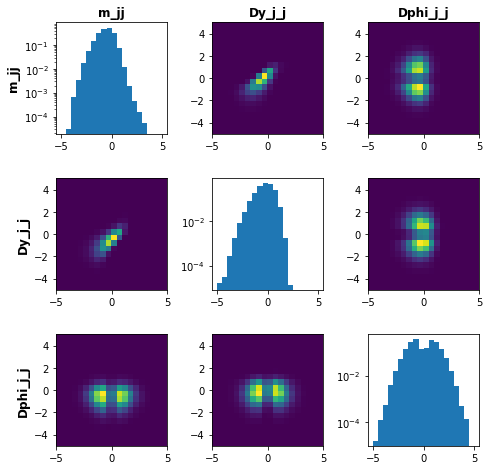

Filter efficiency is 100.000%


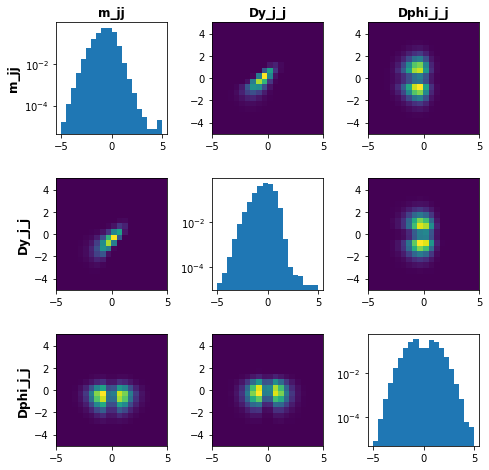

Filter efficiency is 100.000%


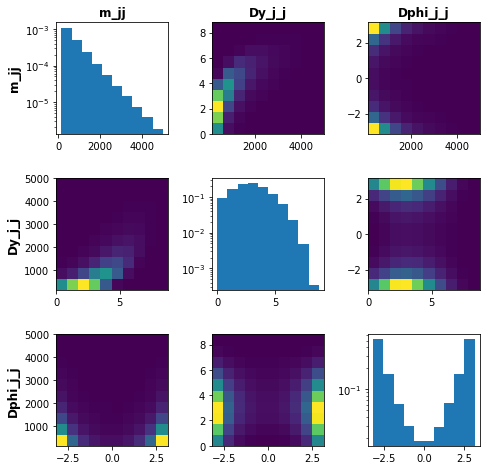

Filter efficiency is 100.000%


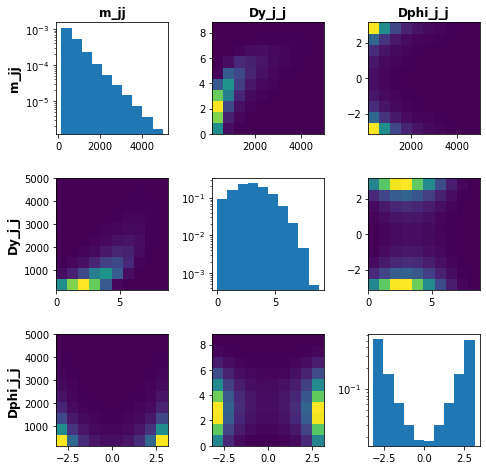

Filter efficiency is 100.000%


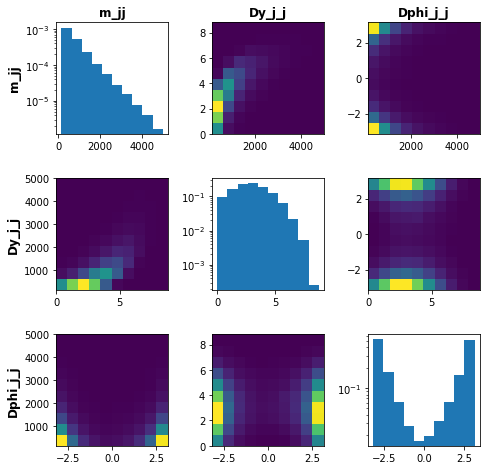

Filter efficiency is 100.000%


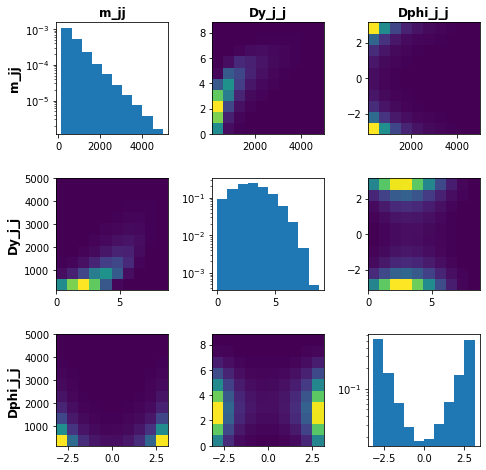

In [12]:
#  Plot original and generate data (total phase space)

plot_data(white_data_to_fit[0.2], weights_to_fit[0.2], keys=data.keys, bins=20, lims=False)
plot_data(fake_white_datapoints[0.2], None, keys=data.keys, bins=20, lims=False)

plot_data(observable_data[0], weights_to_fit[0], keys=data.keys, bins=10)
plot_data(fake_datapoints[0], keys=data.keys, bins=10)

plot_data(observable_data[0.2], weights_to_fit[0.2], keys=data.keys, bins=10)
plot_data(fake_datapoints[0.2], keys=data.keys, bins=10)

In [13]:
#  Plot data (VBF fiducial)

cuts = []
cuts.append(["m_jj"  , 1000, 5000])
cuts.append(["Dy_j_j", 2   , 8.8 ])

#plot_data(observable_data[0.2], weight_data[0.2], cuts=cuts, keys=data.keys, bins=10)
#plot_data(fake_datapoints[0.2], cuts=cuts, keys=data.keys, bins=10)


Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value enco

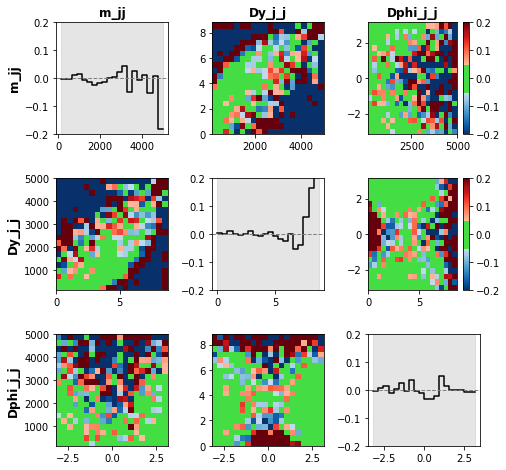

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den


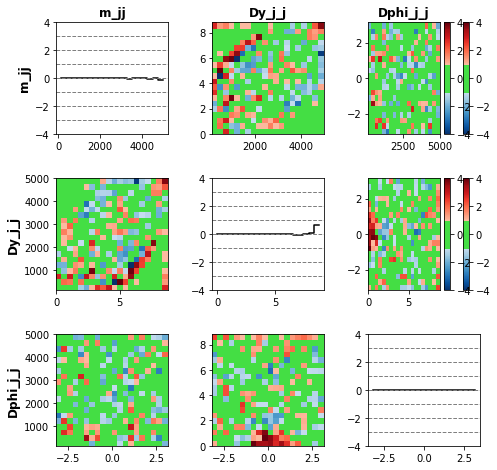

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value enco

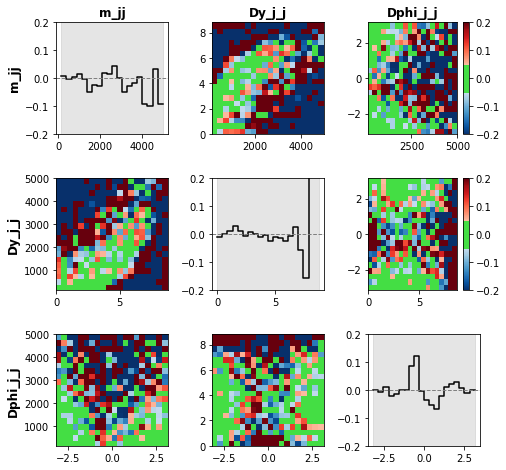

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den


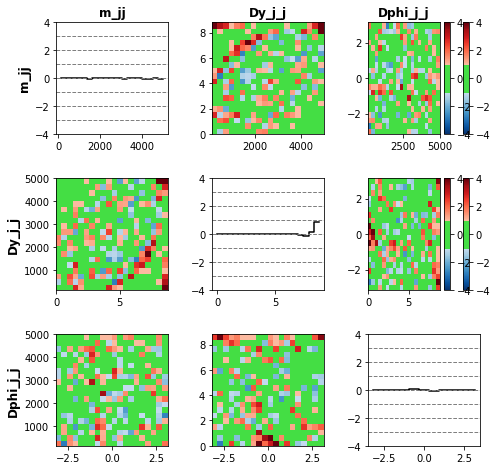

In [14]:
#  Plot ratio and pull between original and generated data (total phase space)

plot_ratio(observable_data[0], fake_datapoints[0], weights_to_fit[0], None, keys=data.keys, bins=20)
plot_pull(observable_data[0], fake_datapoints[0], weights_to_fit[0], None, keys=data.keys, bins=20)

plot_ratio(observable_data[0.2], fake_datapoints[0.2], weights_to_fit[0.2], None, keys=data.keys, bins=20)
plot_pull(observable_data[0.2], fake_datapoints[0.2], weights_to_fit[0.2], None, keys=data.keys, bins=20)



In [15]:
#  Plot ratio between original and generated data (VBF fiducial)

#plot_ratio(observable_data[0], fake_datapoints[0], weight_data[0], None, keys=data.keys, bins=10, cuts=cuts)
#plot_pull(observable_data[0], fake_datapoints[0], weight_data[0], None, keys=data.keys, bins=10, cuts=cuts)

#  Plot pull between original and generated data (VBF fiducial)

#plot_ratio(observable_data[0.2], fake_datapoints[0.2], weight_data[0.2], None, keys=data.keys, bins=10, cuts=cuts)
#plot_pull(observable_data[0.2], fake_datapoints[0.2], weight_data[0.2], None, keys=data.keys, bins=10, cuts=cuts)


In [16]:
from matplotlib import pyplot as plt
from backends.plot import get_ratio_1D

#  Remove events for which key lies outside the interval [minimum, maximum]
#
def filter_data (events, weights, keys, key, minimum, maximum) :
    col_idx = keys.index(key)
    new_events, new_weights = [], []
    for row, weight in zip(events, weights) :
        val = row[col_idx]
        if val < minimum : continue
        if val > maximum : continue
        new_events.append(row)
        new_weights.append(weight)
    return np.array(new_events), np.array(new_weights)


#  Plot the datapoints provided
#
def plot_observable (observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    print(f"Numerator filter efficiency is {100.*np.sum(filtered_weights_num)/np.sum(weights_num):.3f}%")
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    print(f"Denominator filter efficiency is {100.*np.sum(filtered_weights_den)/np.sum(weights_den):.3f}%")
    
    obs_idx = keys.index(observable)
    
    if lims : 
        obs_lims = observable_limits[observable]
    else :
        obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(observable, weight="bold", fontsize=12)    
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color="k", label=label)
    #ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.2, color="grey")
    ax.axhline(0 , linestyle="-", c="grey", linewidth=2)
    ax.axhline(0.1 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.2 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.3 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.4 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.1 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.2 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.3 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.4 , linestyle="--", c="grey", linewidth=0.5)
    ax.set_ylim([-0.9, 0.9])
    
    if type(label) != type(None) :
        ax.legend(loc="upper right", frameon=False, fontsize=16)
    
    plt.show()

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


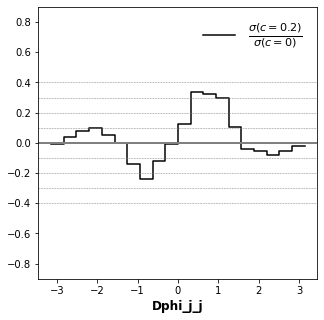

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


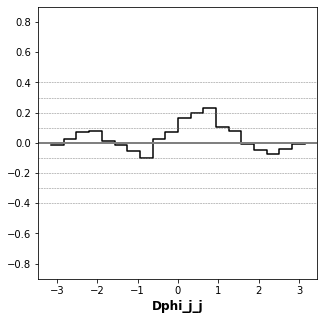

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


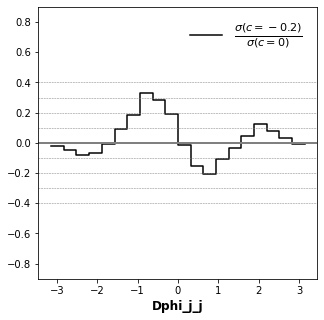

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


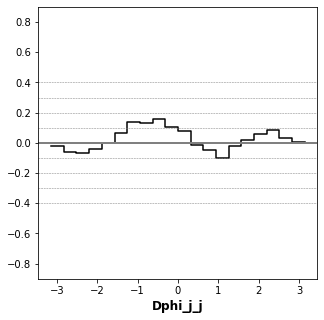

In [24]:

plot_observable("Dphi_j_j", observable_data[0.4], observable_data[0], weights_to_fit[0.4], weights_to_fit[0], keys=data.keys, bins=20, label=r"$\frac{\sigma(c=0.2)}{\sigma(c=0)}$")
plot_observable("Dphi_j_j", fake_datapoints[0.4], fake_datapoints[0], None, None, keys=data.keys, bins=20)

plot_observable("Dphi_j_j", observable_data[-0.4], observable_data[0], weights_to_fit[-0.4], weights_to_fit[0], keys=data.keys, bins=20, label=r"$\frac{\sigma(c=-0.2)}{\sigma(c=0)}$")
plot_observable("Dphi_j_j", fake_datapoints[-0.4], fake_datapoints[0], None, None, keys=data.keys, bins=20)


Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 25.240%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 25.113%


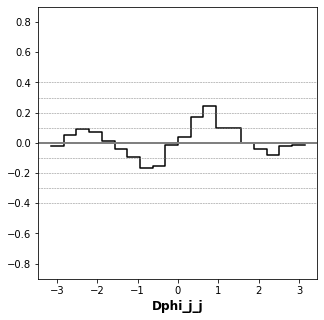

Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 24.894%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 24.913%


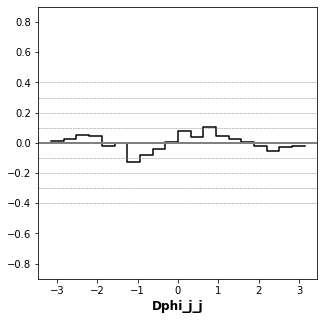

Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 25.132%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 25.113%


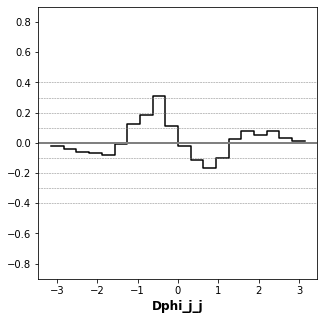

Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 24.939%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 24.913%


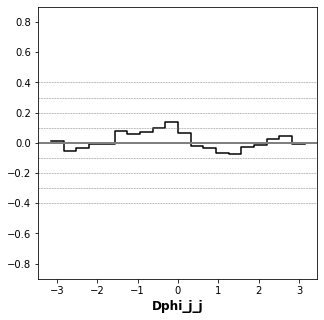

In [18]:

plot_observable("Dphi_j_j", observable_data[0.2], observable_data[0], weight_data[0.2], weight_data[0], keys=data.keys, cuts=cuts, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[0.2], fake_datapoints[0], None, None, keys=data.keys, cuts=cuts, bins=20)



plot_observable("Dphi_j_j", observable_data[-0.2], observable_data[0], weight_data[-0.2], weight_data[0], keys=data.keys, cuts=cuts, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[-0.2], fake_datapoints[0], None, None, keys=data.keys, cuts=cuts, bins=20)


Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


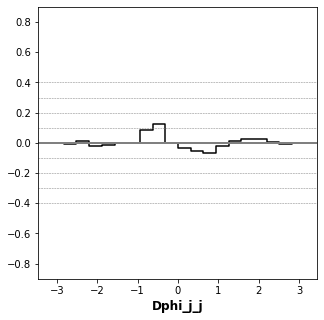

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


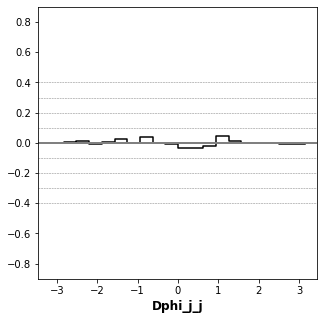

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


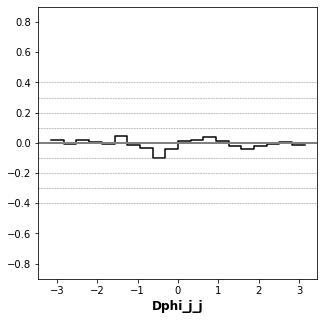

In [19]:

plot_observable("Dphi_j_j", fake_datapoints[0.2], observable_data[0.2], None, weight_data[0.2], keys=data.keys, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[0], observable_data[0], None, weight_data[0], keys=data.keys, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[-0.2], observable_data[-0.2], None, weight_data[-0.2], keys=data.keys, bins=20)


In [20]:
#  Plot the datapoints provided
#
def get_eff (data, weights=None, keys=[], cuts=[]) :
    if type(weights) == type(None) :
        weights = np.ones(shape=(data.shape[0],))
    filtered_data, filtered_weights = data, weights
    for cut in cuts :
        filtered_data, filtered_weights = filter_data (filtered_data, filtered_weights, keys, cut[0], cut[1], cut[2])
    return 100.*np.sum(filtered_weights)/np.sum(weights)


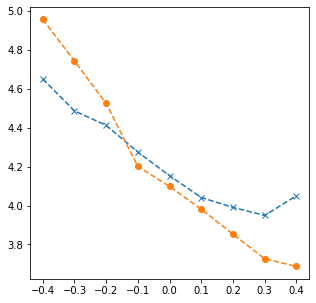

In [21]:
x, y1, y2 = [], [], []
for cWtil in sorted(cWtil_vals) :
    e1 = get_eff(fake_datapoints[cWtil], keys=data.keys, cuts=[["Dphi_j_j", -1.5, 0]])
    e2 = get_eff(observable_data[cWtil], weights_to_fit[cWtil], keys=data.keys, cuts=[["Dphi_j_j", -1.5, 0]])
    x.append(cWtil)
    y1.append(e1)
    y2.append(e2)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y1, "x--")
ax.plot(x, y2, "o--")
plt.show()

In [22]:

data_dict = {}
scan_points = ["m0p4", "m0p3", "m0p2", "m0p1", "0p1", "0p2", "0p3", "0p4"]

for scan_point in scan_points :
    print(scan_point)
    data_EFT = DataTable(f"../Data/cWtil_{scan_point}_full_200k_rivet_output.pickle")
    for observable, limits in observable_limits.items() :
        data_EFT.filter(observable, limits[0], limits[1])
    for observable in remove_observables :
        data_EFT.remove_column(observable)
    data_EFT.reorder(*observables_order)
    data_dict [scan_point] = data_EFT

fname_SM_200k = "../Data/SM_EWK_rivet_output.pickle"
fname_SM_500k = "../Data/SM_EWK_500k_rivet_output.pickle"
fname_SM_1M   = "../Data/SM_EWK_1M_rivet_output.pickle"

data_SM_200k = DataTable(fname_SM_200k)
data_SM_500k = DataTable(fname_SM_500k)
data_SM_1M   = DataTable(fname_SM_1M  )

for observable, limits in observable_limits.items() :
    data_SM_200k.filter(observable, limits[0], limits[1])
    data_SM_500k.filter(observable, limits[0], limits[1])
    data_SM_1M  .filter(observable, limits[0], limits[1])
for observable in remove_observables :
    data_SM_200k.remove_column(observable)
    data_SM_500k.remove_column(observable)
    data_SM_1M  .remove_column(observable)
data_SM_200k.reorder(*observables_order)
data_SM_500k.reorder(*observables_order)
data_SM_1M  .reorder(*observables_order)


m0p4
m0p3
m0p2
m0p1
0p1
0p2
0p3
0p4


==========  m0p4  ==========

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


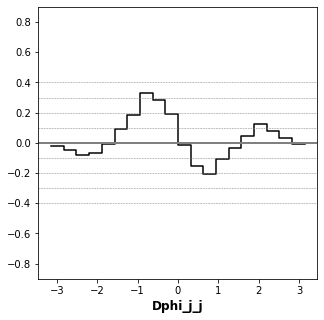

==========  m0p3  ==========

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


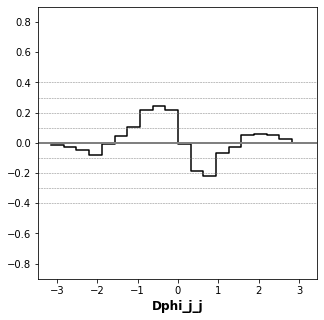

==========  m0p2  ==========

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


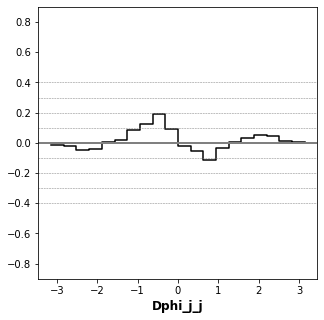

==========  m0p1  ==========

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


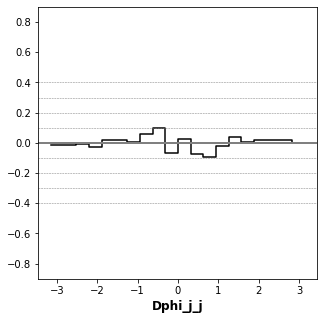

==========  0p1  ==========

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


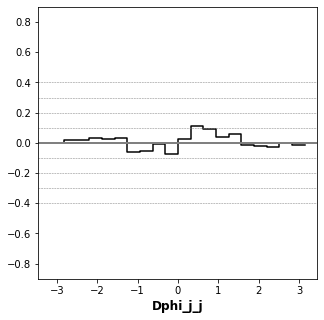

==========  0p2  ==========

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


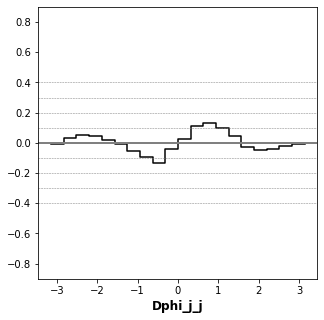

==========  0p3  ==========

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


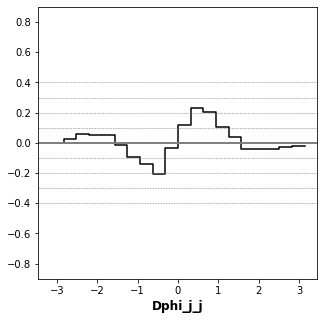

==========  0p4  ==========

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


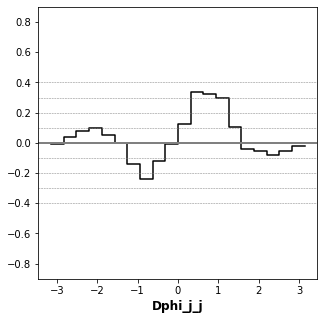

In [23]:

for scan_point in scan_points :
    print( "="*(24+len(scan_point)))
    print(f"==========  {scan_point}  ==========")
    print( "="*(24+len(scan_point)))
    print()
    data_EFT = data_dict[scan_point]
    plot_observable("Dphi_j_j", data_EFT.data, data_SM_1M  .data, data_EFT.get_weights(), data_SM_1M  .get_weights(), keys=data.keys, bins=20)
    #plot_observable("Dphi_j_j", data_EFT.data, data_SM_500k.data, data_EFT.get_weights(), data_SM_500k.get_weights(), keys=data.keys, bins=20)
    #plot_observable("Dphi_j_j", data_EFT.data, data_SM_200k.data, data_EFT.get_weights(), data_SM_200k.get_weights(), keys=data.keys, bins=20)
